<a href="https://colab.research.google.com/github/bingsen-wang/Electric-Machines/blob/main/Simulation_InductionMachine_StRF_MotorToGenerator_anim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Simulation: Induction Motor to Generator in Stationary Reference Frame</h1></b>

Dr. Bingsen Wang

7/13/2025
</center>

In stationary reference frame, the dynamic equations in matrix form are
In matrix form, (22) is rewritten as
$$
\underbrace{\left[\begin{array}{cc}L_s & L_m \\ L_m & L_r\end{array}\right]}_{A}
\begin{bmatrix}{d\underline i_s\over dt}\\ {d\underline i_r\over dt}\end{bmatrix}
= \underbrace{\begin{bmatrix}-R_s & 0\\
j\omega_r L_m & -R_r +j\omega_r L_r\end{bmatrix}}_{B}
\begin{bmatrix}\underline i_s\\
\underline i_r\end{bmatrix}
+ \begin{bmatrix}\underline v_s\\ \underline v_r\end{bmatrix}
\tag{1}$$

#Python Code

0
0
100
200
300
400
500
600
700
0


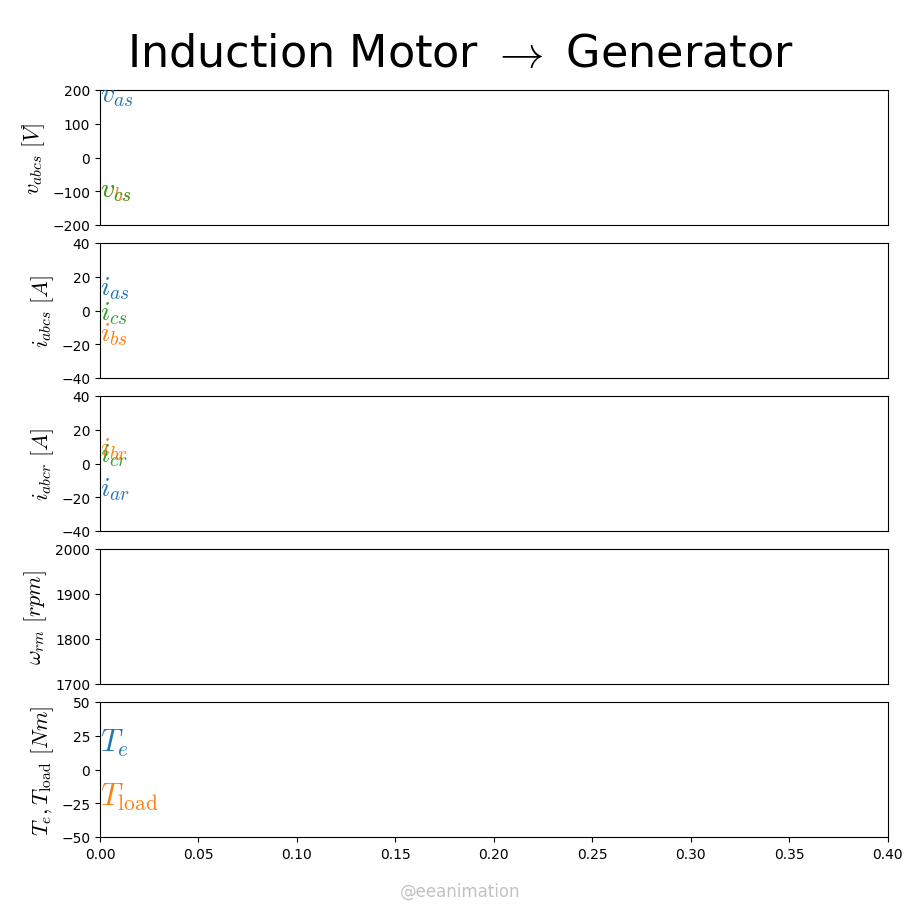

In [3]:
from matplotlib import pyplot,animation,cm
import numpy as np; from scipy.integrate import odeint
pyplot.rcParams.update({"font.family":"sans-serif", "mathtext.fontset":"cm"})
sv2abc=lambda sv: [sv.real,(sv*np.exp(-1j*2*np.pi/3)).real,(sv*np.exp(-1j*4*np.pi/3)).real]
TL =lambda t,t1: 20-60*np.heaviside(t-t1,0)
c2ir =lambda c: list(np.array(c).real)+list(np.array(c).imag)
vs=lambda t,Vll_rms,omega: np.sqrt(2/3)*Vll_rms*np.exp(1j*omega*t)
def inductionMachine(x,t,rs,rr,Ls,Lr,Lm,Npp,Vll_rms,omega,J,T1):
  isr,wrm=[x[0]+1j*x[2],x[1]+1j*x[3]],x[4]; wr=wrm*Npp
  A=np.array([[Ls,Lm],[Lm,Lr]]); Ainv=np.linalg.inv(A)
  B=np.array([[-rs,0],[1j*wr*Lm,-rr+1j*wr*Lr]])
  Te=3/2*Npp*Lm*(isr[0]*np.conj(isr[1])).imag
  didt=Ainv@B@isr+Ainv@[vs(t,Vll_rms,omega),0]; dwrm=(Te-TL(t,T1))/J #dynamic equations
  return [*c2ir(didt),dwrm,Te,*isr,-TL(t,T1)]
sys=lambda x,t,*args: inductionMachine(x,t,*args)[:5]

#Parameters
rs,rr = 0.531,0.408; Lls=Llr = 2.52e-3;Lm = 84.7e-3;Npp = 2; J = 0.1
Vll_rms=230; omega = 2*np.pi*60
t_start=0;  t_step=1e-3;

#simulation by odeint
x0=np.array([0,0,0,0,0]); t_end=1.5;t=np.arange(t_start,t_end+t_step,t_step)
args=(rs,rr,Lls+Lm,Llr+Lm,Lm,Npp,Vll_rms,omega,J,t_end)
x_sol=odeint(sys,x0,t,args=args);x0=x_sol[-1,:] #reset the initial conditions
t_end=.4;t_step=.5e-3;t=np.arange(t_start,t_end,t_step)
args=(rs,rr,Lls+Lm,Llr+Lm,Lm,Npp,Vll_rms,omega,J,t_end*.4)
x_sol=odeint(sys,x0,t,args=args)#resimulate without transient
Te=[inductionMachine(x_sol[k,:],t[k],*args)[5] for k in range(len(t))]
is_sv=[inductionMachine(x_sol[k,:],t[k],*args)[6] for k in range(len(t))]
ir_sv=[inductionMachine(x_sol[k,:],t[k],*args)[7] for k in range(len(t))]
Tld=[inductionMachine(x_sol[k,:],t[k],*args)[8] for k in range(len(t))]
vabc=sv2abc(vs(t,Vll_rms,omega))
iabcs=sv2abc(np.array(is_sv))
iabcr=sv2abc(np.array(ir_sv))

cl = list(cm.tab10.colors) #colors of lines
fig = pyplot.figure(figsize=([9,9]))
ax=fig.add_axes([0,0,1,1],xlim=[0,1]);ax.axis('off')
ax.text(.5,.95,r"Induction Motor $\rightarrow$ Generator",size=32,ha='center',va='center')
axs = [fig.add_axes([.1,.08+(4-k)*.17,.875,.15],xlim=[0,t_end],fc='none') for k in range(5)]
[axs[k].set_xticks([]) for k in range(4)]
[axs[k].set_ylabel([r'$v_{abc s}\ [V]$',r'$i_{abc s}\ [A]$',r'$i_{abc r}\ [A]$',r'$\omega_{rm}\ [rpm]$',r'$T_e,T_\text{load}\ [Nm]$'][k],size=16)for k in range(5)]
[axs[k].set_ylim([[-200,200],[-40,40],[-40,40],[1700,2000],[-50,50]][k]) for k in range(5)]
lines=[axs[k].plot([],[],c=cl[i],lw=2)[0] for k in range(3) for i in range(3)]
lines+=[axs[3].plot([],[],c=cl[3],lw=2)[0] ]
lines+=[axs[4].plot([],[],c=cl[k],lw=2)[0] for k in range(2)]
txts=[axs[k].text(0,0,[['$v_{as}$','$v_{bs}$','$v_{cs}$'],['$i_{as}$','$i_{bs}$','$i_{cs}$'],
 ['$i_{ar}$','$i_{br}$','$i_{cr}$']][k][i],c=cl[i],size=20,va='center') for k in range(3) for i in range(3)]
txts+=[axs[4].text(0,0,['$T_e$',r'$T_\text{load}$'][k],c=cl[k],size=22,va='center') for k in range(2)]

def update(i):
  if i%100==0: print(i) #for monitoring
  [lines[k+3*kk].set_data(t[:i+1],[vabc,iabcs,iabcr][kk][k][:i+1]) for kk in range(3) for k in range(3)]
  [txts[k+3*kk].set_position((t[i],[vabc,iabcs,iabcr][kk][k][i])) for kk in range(3) for k in range(3)]
  lines[9].set_data(t[:i+1],x_sol[:i+1,4]*60/(2*np.pi))
  [lines[10+k].set_data(t[:i+1],[Te,Tld][k][:i+1])for k in range(2)]
  [txts[k+9].set_position((t[i],[Te,Tld][k][i])) for k in range(2)]
  return

ax.text(np.average(ax.get_xlim()),ax.get_ylim()[0]*.99+ax.get_ylim()[1]*.01,r'@eeanimation',size=12,c='.2',alpha=.3,ha='center',va='bottom')
anim = animation.FuncAnimation(fig, update, frames=len(t))
anim.save("inductionMotor2Generator.mp4",writer=animation.FFMpegWriter(fps=60),dpi=200)